In [1]:
import os
import sys
import torch
import scipy
import scipy.io
import cvxpy as cp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import medfilt, savgol_filter, wiener
from scipy.linalg import pinv
from tqdm import tqdm

sys.path.append('../')
from preprocessing import *
os.chdir('../../SpectraFit/')
import data_processing.preprocessing as preprocessing
from config import dataset_path
from utils import beerlamb_multi

Text(0.5, 1.0, 'Reference spectrum')

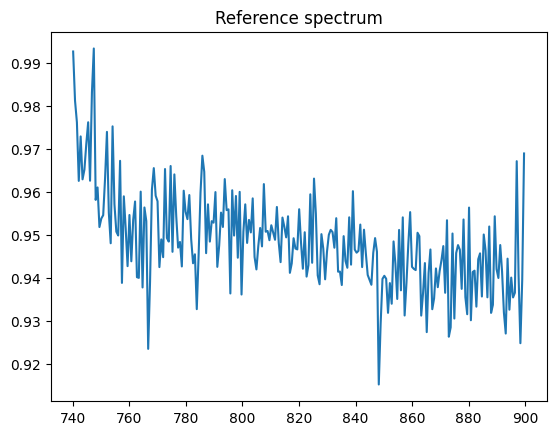

In [2]:
left_cut = 740
right_cut = 900
reference_index = 100 # starting spectrum for inference
time_cut = 500 # at what timepoint to stop inference

# load data
img_mat = scipy.io.loadmat(dataset_path + 'LWP498/LWP498_Ws_24Apr2017_15.mat')
dark_ref = scipy.io.loadmat(dataset_path + 'LWP498/LWP498 _DarkCount_24Apr2017.mat')['DarkCount'].astype(float) # shape (k,n)
white_ref = img_mat['refIntensity'].astype(float) # shape (k,m)
spectr = img_mat['spectralDataAll'].astype(float)[:,:time_cut].T # shape (time_cut, k)
band_centers = img_mat['wavelengths'].astype(float).squeeze() # shape (k,)
concentrations_paper = img_mat['AllConcentration']

#To find HI_start and HI_stop:
#we take the row in the Excel where FiO2 drops, but need to add offset as Excel file starts at different timepoint
HI_start = 143
HI_stop = 274
outcome = 0

# average dark and white reference and add dimension for shape (1,k)
white_ref = np.mean(white_ref, axis=-1)[np.newaxis, :]
dark_ref = np.mean(dark_ref, axis=-1)[np.newaxis, :]

# extract wavelengths between 760 and 900
band_limits = [left_cut, right_cut]
spectr, _ = band_removal(spectr, band_limits, band_centers)
white_ref, _ = band_removal(white_ref, band_limits, band_centers)
dark_ref, band_centers_new = band_removal(dark_ref, band_limits, band_centers)


# calibrate spectra
spectr_calib = calibrate_img(spectr, white_ref, dark_ref)
ref_spectr_calib = spectr_calib[reference_index, :]

# plot reference spectrum
plt.figure()
plt.plot(band_centers_new, ref_spectr_calib)
plt.title("Reference spectrum")

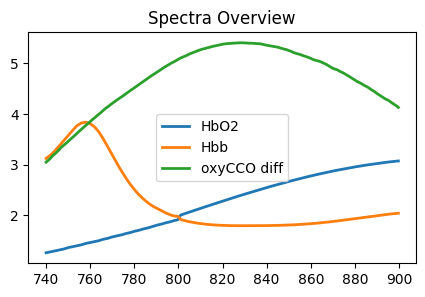

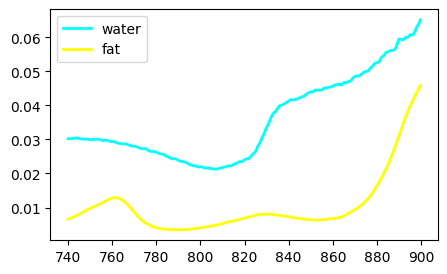

In [3]:
# load cytochrome spectra
molecules, x = preprocessing.read_molecules(left_cut, right_cut, band_centers_new)
y_hbo2_f, y_hb_f, y_coxa, y_creda, y_water, y_fat = molecules

M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                            np.asarray(y_hb_f),
                            np.asarray(y_coxa - y_creda))))
M_pinv = pinv(M)
m = M.shape[1] # number of cytochromes to fit

# plot cytochrome spectra
plt.figure(figsize=(5,3))
coef = ["HbO2", "Hbb", "oxyCCO diff"]
coef_list = [y_hbo2_f, y_hb_f, y_coxa-y_creda]
for i in range(len(coef)):
    plt.plot(band_centers_new, M[:,i], label=coef[i], linewidth=2)
plt.title("Spectra Overview")
plt.legend()
plt.figure(figsize=(5,3))
plt.plot(band_centers_new, y_water, color="cyan", label="water", linewidth=2)
plt.plot(band_centers_new, y_fat, color="yellow", label="fat", linewidth=2)
plt.legend()

In [4]:
def plot_concentrations_paper(concentrations):
        plt.figure(figsize=(8,4))
        coef_list = np.vstack(concentrations)
        colors = ['#ff7f0e', '#1f77b4', '#2ca02c','#d62728']
        coef = ["Hbb","HbO2","diff oxyCCO","HbT"]
        
        for i in range(len(coef)):
            plt.plot(np.arange(reference_index, time_cut),coef_list[reference_index:time_cut, i], label=coef[i], color=colors[i], linewidth=2)
            
        plt.title("Concentrations inferred in Paper")
        plt.legend()

def plot_concentrations(c_i_list, title):
        plt.figure(figsize=(8,4))
        c_i_list = np.vstack(c_i_list)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        coef = ["HbO2", "Hbb","diff oxyCCO","diff cc red","water","fat"]
        
        for i in range(m):
            if coef[i] == "water" or coef[i] == "fat":
                plt.plot(np.arange(reference_index, time_cut), c_i_list[:, i]/10, label=coef[i]+"/10", linewidth=2)
            else:
                plt.plot(np.arange(reference_index, time_cut), c_i_list[:, i], label=coef[i], linewidth=2)
            
        plt.plot(np.arange(reference_index, time_cut), c_i_list[:, 0] + c_i_list[:,1], color='#d62728', label="HbT",linewidth=2)
        plt.title(title)
        plt.legend()            
    
def plot_a_b(a_s, b_s):
    fig, axs = plt.subplots(2, 1, figsize=(16,9))
    b_s = np.vstack(b_s)
    a_s = np.vstack(a_s)
    axs[0].plot(b_s[:, 0], label="b", linewidth=2)
    axs[1].plot(a_s[:, 0], label="a_1", linewidth=0.5, color='purple')
    plt.legend()

## Fan Model 
$$
\Delta A(t,\lambda)=\sum_{i=1}^{R}\mu_{i}(\lambda)\Delta c_i(t) + \sum_{i=1}^{R-1} \sum_{j=i+1}^{R} \bigl(\mu_i(\lambda) \odot \mu_j(\lambda)\bigr) \Delta c_i(t) \Delta c_j(t) = \newline
= \sum_{i=1}^{R}\mu_{i}(\lambda)\Delta c_i(t) + \frac{1}{2} \sum_{i=0}^{R} \sum_{j=0}^{R} \bigl(\mu_i(\lambda) \odot \mu_j(\lambda)\bigr) \Delta c_i(t) \Delta c_j(t) - \frac{1}{2} \sum_{i=0}^{R} \bigl(\mu_i(\lambda) \odot \mu_i(\lambda)\bigr) \Delta c_i(t) \Delta c_i(t)
$$

$$
\frac{\partial \Delta A}{\partial \Delta c_i} = \mu_{i}(\lambda) + \frac{1}{2} \sum_{j=0}^{R} \bigl(\mu_i(\lambda) \odot \mu_j(\lambda)\bigr) \Delta c_j(t) - \bigl(\mu_i(\lambda) \odot \mu_i(\lambda)\bigr) \Delta c_i(t)
$$

In [24]:
# error function for optimisation of fan model
def f(X,*arg):
    delta_A = arg[0]
    M = arg[1] # cytochrome spectra
    m = M.shape[1]
    delta_c_i = X[:m]
    residual = (M @ delta_c_i) +  - delta_A
    for i in range(0,m-1):
        for j in range(i+1,m):
            residual = residual + delta_c_i[i] * delta_c_i[j] * M[:,i] * M[:,j]
    return residual

def fan_model(spectr, M, need_plot=True):
    
    delta_c_i_list = []
    error_list = []
    
    #initial_estimation = [0,0,0] (for delta_c_1, ..., delta_c_m)
    m = M.shape[1]
    current_x = np.zeros(m)
    left_bound = np.ones(m)*(-np.inf)
    right_bound = np.ones(m)*np.inf
    
    ref_spectr = spectr[reference_index, :]
    for i in range(reference_index, time_cut):
        spectr_t2 = spectr[i, :]
        spectr_t2[spectr_t2 <= 0] = 0.0001    
        delta_A = np.log(np.divide(ref_spectr, spectr_t2))
        result = scipy.optimize.least_squares(f, current_x, args=(delta_A, M), bounds=(left_bound, right_bound))
        current_x = result.x

        delta_c_i_list.append(result.x[:m])
        error_list.append(np.sqrt(2*result.cost)) # L2 norm of residual
    
        found_spectrum = f(result.x, *(0, M))
        
        if need_plot and i % 50 == 0:
            plt.figure()
            plt.plot(band_centers_new, -np.log(spectr_t2 / ref_spectr), label='GT Attenuation', linewidth=0.5)
            plt.plot(band_centers_new, found_spectrum, label='Simulated with Fan Model', linewidth=3)
            plt.title("i=" + str(i))
            plt.legend()

    if need_plot:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(delta_c_i_list, "Simulated with Fan Model")

    return np.mean(error_list), np.array(delta_c_i_list)

In [25]:
spectr_calib_smooth = smooth_spectral(spectr_calib, 5)
M_water = np.hstack((M, y_water[:, np.newaxis]))
M_ones = np.hstack((M, np.ones((M.shape[0], 1))))
M_water_ones = np.hstack((M_ones, y_water[:, np.newaxis]))

error, delta_c_i_list = fan_model(spectr_calib_smooth, M, need_plot=False)
print("Mean error:", error)

error, delta_c_i_list = fan_model(spectr_calib_smooth, M_water, need_plot=False)
print("Mean error:", error)

error, delta_c_i_list = fan_model(spectr_calib_smooth, M_ones, need_plot=False)
print("Mean error:", error)

error, delta_c_i_list = fan_model(spectr_calib_smooth, M_water_ones, need_plot=False)
print("Mean error:", error)

Mean error: 0.2268134891133408
Mean error: 0.2102708414266999
Mean error: 0.19410296863604706
Mean error: 0.1838636476497806


## Generalized Bilinear Model
$$
\Delta A(t,\lambda)=\sum_{i=1}^{R}\mu_{i}(\lambda)\Delta c_i(t) + \sum_{i=1}^{R-1} \sum_{j=i+1}^{R} \bigl(\mu_i(\lambda) \odot \mu_j(\lambda)\bigr) \Delta c_i(t) \Delta c_j(t) \gamma_{i,j}(t)
$$

In [114]:
# error function for optimisation of GBM
def f(X,*arg):
    delta_A = arg[0]
    M = arg[1] # cytochrome spectra
    m = M.shape[1]
    delta_c_i = X[:m]
    gamma = X[m:]
    residual = (M @ delta_c_i) +  - delta_A
    gamma_idx = 0
    for i in range(0,m-1):
        for j in range(i+1,m):
            residual = residual + gamma[gamma_idx] * delta_c_i[i] * delta_c_i[j] * M[:,i] * M[:,j]
            gamma_idx += 1
    residual += 10*np.inner(gamma, gamma)
    return residual

def gbm(spectr, M, need_plot=True):
    
    delta_c_i_list = []
    gamma_list = []
    error_list = []
    
    #initial_estimation = [0,0,0] (for delta_c_1, ..., delta_c_m, gamma_12, gamma_13, ...gamma_(m-1)m )
    m = M.shape[1]
    n = int(m*(m-1)/2)
    current_x = np.zeros(m + n)
    left_bound = np.ones(m + n)*(-np.inf)
    right_bound = np.ones(m + n)*np.inf
    
    ref_spectr = spectr[reference_index, :]
    for i in range(reference_index, time_cut):
        spectr_t2 = spectr[i, :]
        spectr_t2[spectr_t2 <= 0] = 0.0001    
        delta_A = np.log(np.divide(ref_spectr, spectr_t2))
        result = scipy.optimize.least_squares(f, current_x, args=(delta_A, M), bounds=(left_bound, right_bound))
        current_x = result.x

        delta_c_i_list.append(result.x[:m])
        gamma_list.append(result.x[m:])
        error_list.append(np.sqrt(2*result.cost)) # L2 norm of residual
    
        found_spectrum = f(result.x, *(0, M))
        
        if need_plot and i % 50 == 0:
            plt.figure()
            plt.plot(band_centers_new, -np.log(spectr_t2 / ref_spectr), label='GT Attenuation', linewidth=0.5)
            plt.plot(band_centers_new, found_spectrum, label='Simulated with Fan Model', linewidth=3)
            plt.title("i=" + str(i))
            plt.legend()

    if need_plot:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(delta_c_i_list, "Simulated with Fan Model")

    return np.mean(error_list), np.array(delta_c_i_list), np.array(gamma_list)

Mean error: 0.06628421350158784


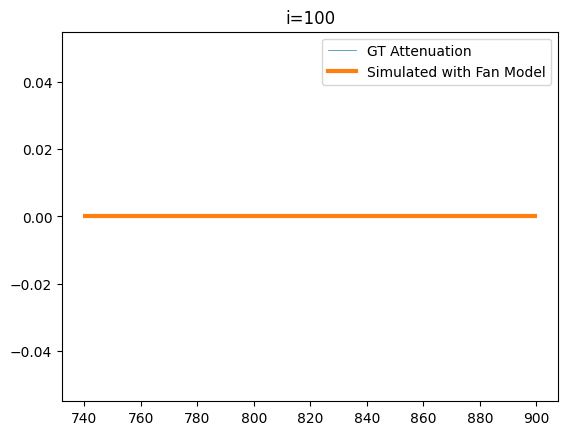

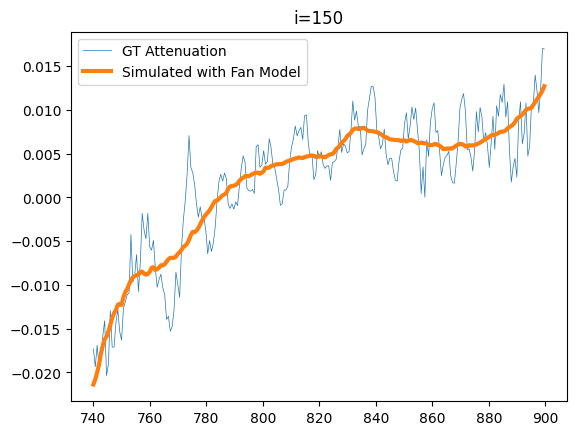

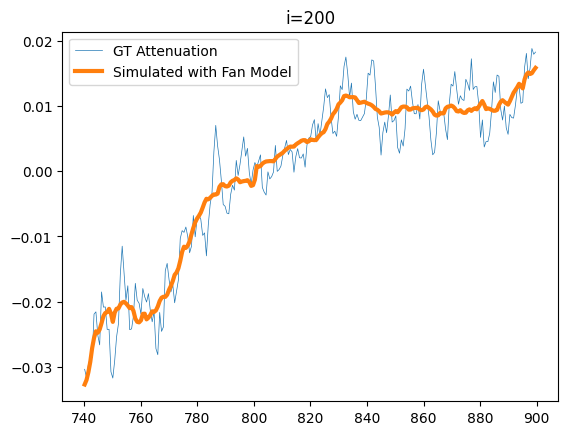

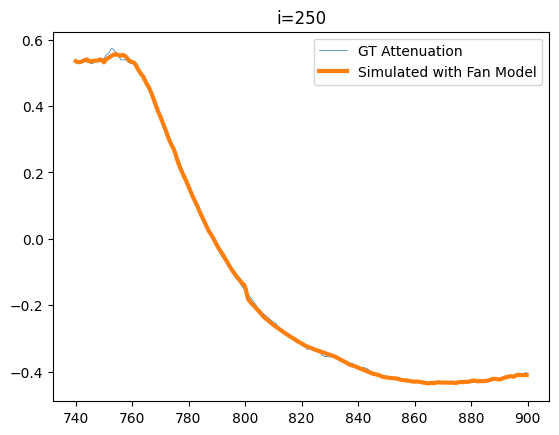

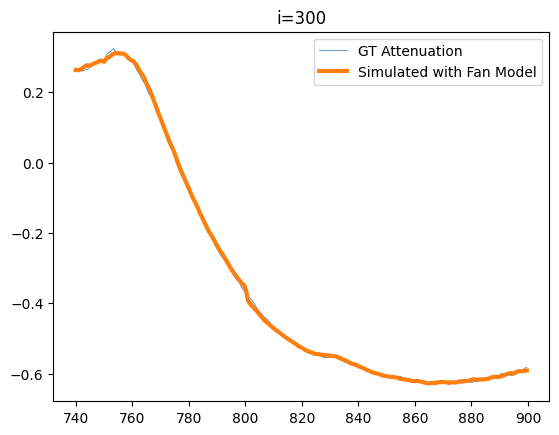

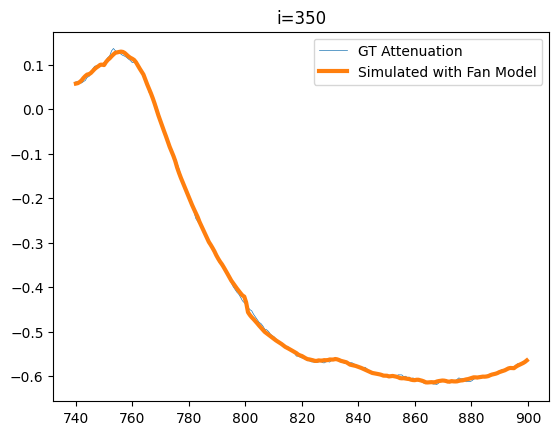

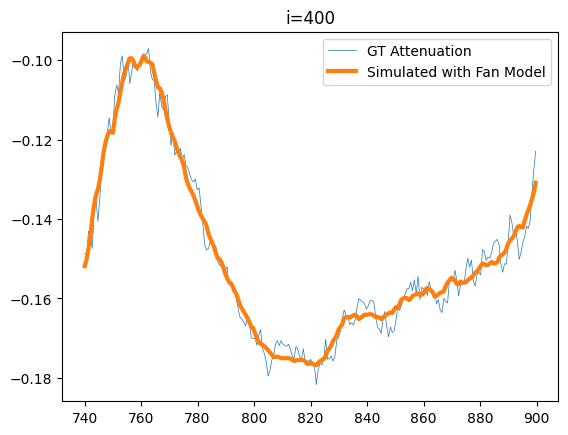

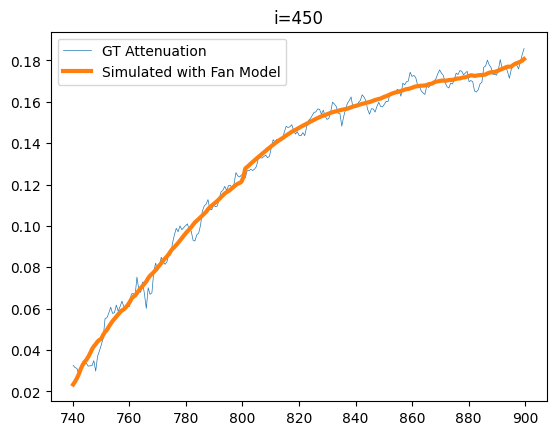

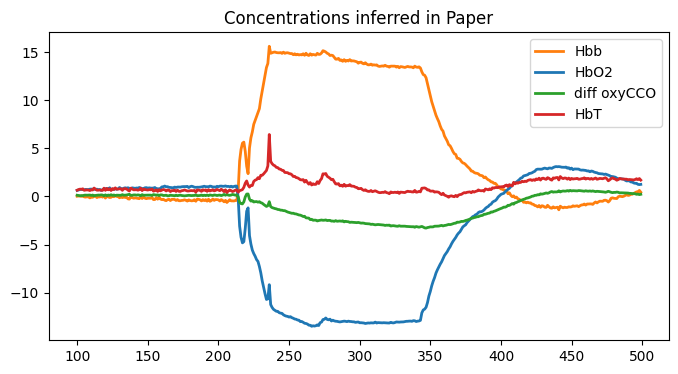

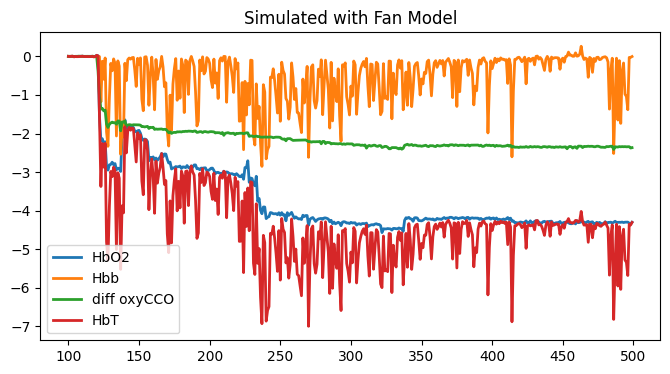

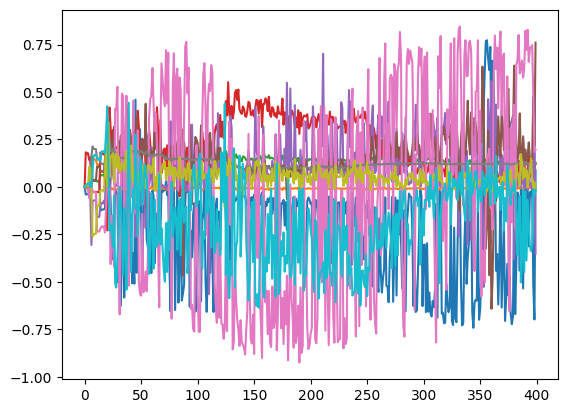

In [115]:
spectr_calib_smooth = smooth_spectral(spectr_calib, 5)
M_water = np.hstack((M, y_water[:, np.newaxis]))
M_ones = np.hstack((M, np.ones((M.shape[0], 1))))
M_water_ones = np.hstack((M_ones, y_water[:, np.newaxis]))

# error, delta_c_i_list, gamma_list = gbm(spectr_calib_smooth, M, need_plot=True)
# print("Mean error:", error)
# plt.figure()
# plt.plot(gamma_list)

# error, delta_c_i_list, gamma_list = gbm(spectr_calib_smooth, M_water, need_plot=True)
# print("Mean error:", error)
# plt.figure()
# plt.plot(gamma_list)

# error, delta_c_i_list, gamma_list = gbm(spectr_calib_smooth, M_ones, need_plot=True)
# print("Mean error:", error)
# plt.figure()
# plt.plot(gamma_list)

error, delta_c_i_list, gamma_list = gbm(spectr_calib_smooth, M_water_ones, need_plot=True)
print("Mean error:", error)
plt.figure()
plt.plot(gamma_list)



In [112]:
class Fan_Model:
    def __init__(self, M):
        self.M = M
        self.m = self.M.shape[1]
        self.M_hadamard = np.zeros((M.shape[0], self.m, self.m))
        for i in range(self.m):
            for j in range(self.m):
                self.M_hadamard[:,i,j] = M[:,j] * M[:,i]

    def predict(self):
        pred = self.M @ self.delta_c_i
        for i in range(0,self.m-1):
            for j in range(i+1,self.m):
                pred = pred + self.delta_c_i[i] * self.delta_c_i[j] * self.M[:,i] * self.M[:,j]
        return pred

    def gradient(self):
        grad_residual = self.M
        for i in range(self.m):
            grad_residual[:,i] += self.M_hadamard[:,:,i] @ self.delta_c_i - self.M[:,i] * self.M[:,i] * self.delta_c_i[i]
        self.grad_residual = grad_residual
        grad_error = self.residual.T @ grad_residual
        # print(grad_error)
        return grad_error

    def hessian(self):
        hess_residual = self.M_hadamard * 0.5
        for i in range(self.m):
            hess_residual[:,i,i] = np.zeros(self.M.shape[0])
        hess_error = 0.5 * (hess_residual.T @ self.residual + np.einsum('j,jkl->kl', self.residual, hess_residual) + self.grad_residual.T @ self.grad_residual)
        return hess_error

    def step(self, delta_A, lr=0.0000005):
        grad_error = self.gradient()
        jacob_error = self.hessian()
        # self.delta_c_i -= lr* np.linalg.lstsq(jacob_error, grad_error)[0]
        self.delta_c_i -= lr* grad_error
        self.residual = self.predict() - delta_A
        error = 0.5*np.inner(self.residual, self.residual)
        print(error)
        return error

    def fit(self, delta_c_i, delta_A, need_plot=False):
        self.delta_c_i = delta_c_i
        self.residual = self.predict() - delta_A
        error_list = []
        for i in range(200):
            error = self.step(delta_A)
            error_list.append(error)
        
        if need_plot:
            plt.figure()
            plt.plot(error_list)

        return self.delta_c_i.copy(), error

0.0021360630773612616
0.0021343233772843973
0.0021325973336400413
0.002130884820345275
0.002129185712767991
0.0021274998877076484
0.0021258272233762926
0.0021241675993798528
0.0021225208966997072
0.002120886997674514
0.0021192657859823013
0.0021176571466228183
0.0021160609659001297
0.0021144771314054707
0.002112905532000336
0.002111346057799815
0.0021097986001561626
0.0021082630516426073
0.0021067393060373823
0.0021052272583079908
0.0021037268045956854
0.0021022378422001714
0.0021007602695645327
0.0020992939862603554
0.0020978388929730725
0.0020963948914875167
0.002094961884673661
0.002093539776472578
0.002092128471882582
0.0020907278769455744
0.002089337898733573
0.002087958445335434
0.002086589425843758
0.002085230750341978
0.002083882329891626
0.00208254407651978
0.002081215903206678
0.0020798977238735156
0.0020785894533704016
0.002077291007464484
0.002076002302828244
0.0020747232570279416
0.0020734537885122328
0.0020721938166009353
0.002070943261473951
0.0020697020441603387
0.00206

C:\Users\User\AppData\Local\Temp\ipykernel_18904\583406661.py:11: RuntimeWarning: overflow encountered in matmul
  pred = self.M @ self.delta_c_i
C:\Users\User\AppData\Local\Temp\ipykernel_18904\583406661.py:14: RuntimeWarning: overflow encountered in scalar multiply
  pred = pred + self.delta_c_i[i] * self.delta_c_i[j] * self.M[:,i] * self.M[:,j]
C:\Users\User\AppData\Local\Temp\ipykernel_18904\583406661.py:14: RuntimeWarning: invalid value encountered in add
  pred = pred + self.delta_c_i[i] * self.delta_c_i[j] * self.M[:,i] * self.M[:,j]
C:\Users\User\AppData\Local\Temp\ipykernel_18904\583406661.py:20: RuntimeWarning: overflow encountered in multiply
  grad_residual[:,i] += self.M_hadamard[:,:,i] @ self.delta_c_i - self.M[:,i] * self.M[:,i] * self.delta_c_i[i]
C:\Users\User\AppData\Local\Temp\ipykernel_18904\583406661.py:30: RuntimeWarning: overflow encountered in matmul
  hess_error = 0.5 * (hess_residual.T @ self.residual + np.einsum('j,jkl->kl', self.residual, hess_residual) + se

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


ValueError: x and y must have same first dimension, but have shapes (400,) and (399,)

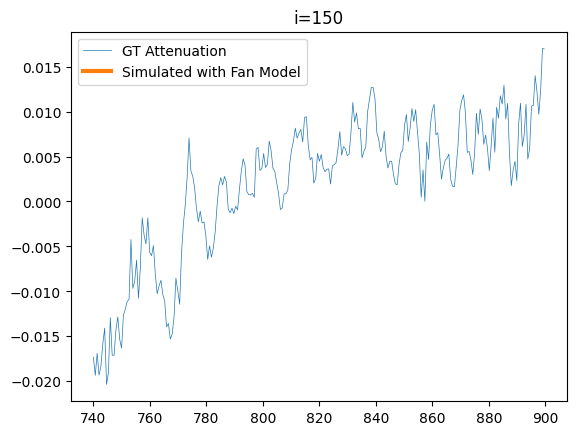

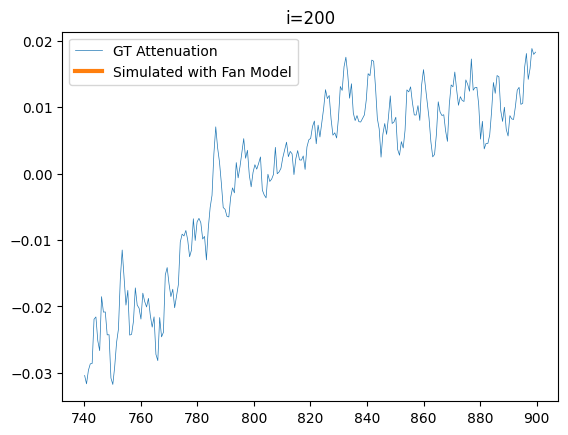

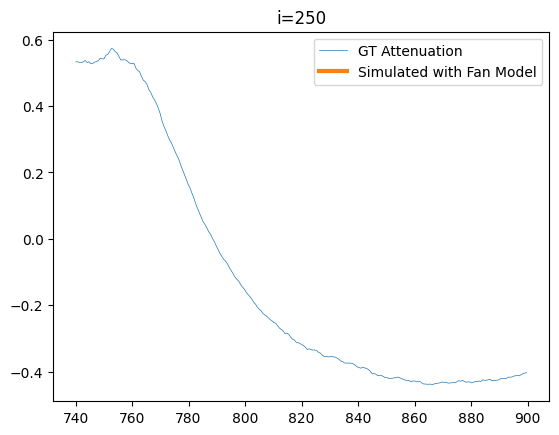

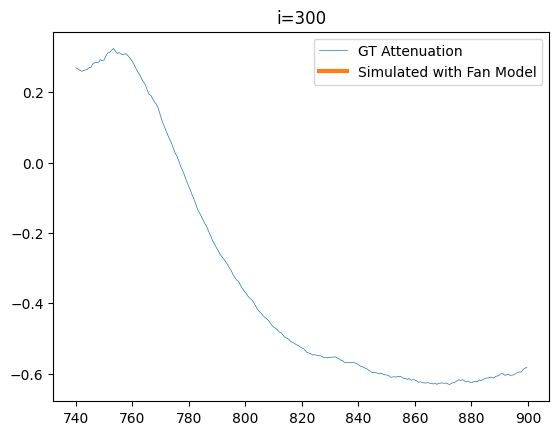

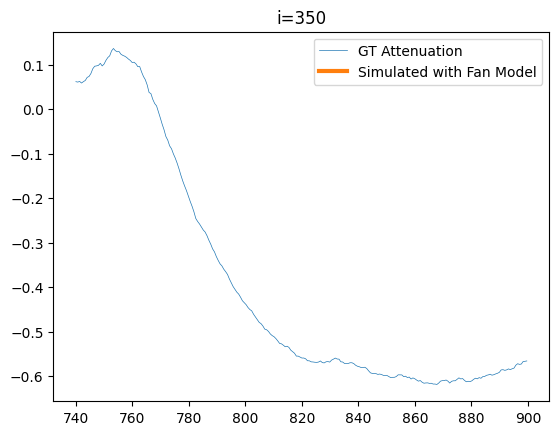

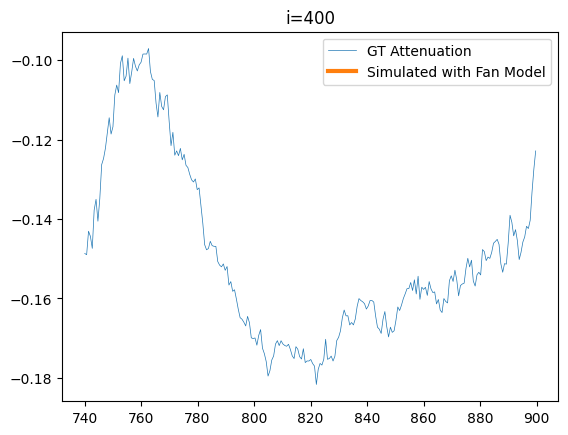

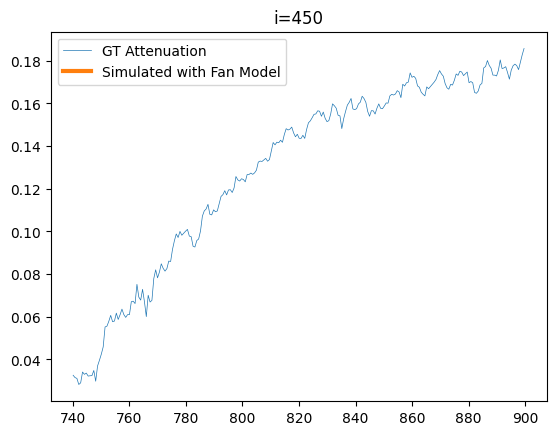

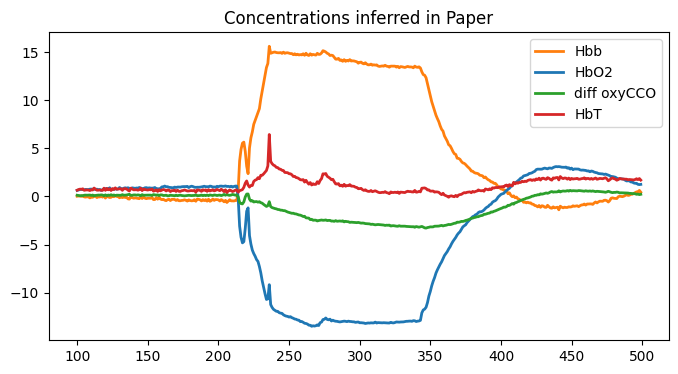

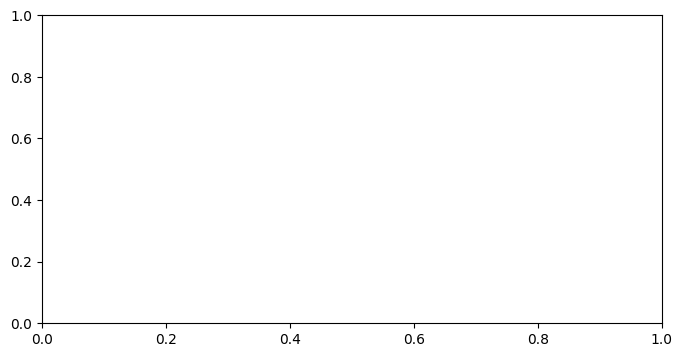

In [113]:
def fan_model(spectr, M, need_plot=True):
    
    delta_c_i_list = []
    error_list = []
    
    #initial_estimation = [0,0,0] (for delta_c_1, ..., delta_c_m)
    m = M.shape[1]
    current_x = np.zeros(m)
    model = Fan_Model(M)
    
    ref_spectr = spectr[reference_index, :]
    for i in range(reference_index+1, time_cut):
        spectr_t2 = spectr[i, :]
        spectr_t2[spectr_t2 <= 0] = 0.0001    
        delta_A = np.log(np.divide(ref_spectr, spectr_t2))
        current_x, cost = model.fit(current_x, delta_A)

        delta_c_i_list.append(current_x)
        error_list.append(np.sqrt(2*cost)) # L2 norm of residual
    
        found_spectrum = model.predict()
        
        if need_plot and i % 50 == 0:
            plt.figure()
            plt.plot(band_centers_new, -np.log(spectr_t2 / ref_spectr), label='GT Attenuation', linewidth=0.5)
            plt.plot(band_centers_new, found_spectrum, label='Simulated with Fan Model', linewidth=3)
            plt.title("i=" + str(i))
            plt.legend()

    del(model)
    if need_plot:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(delta_c_i_list, "Simulated with Fan Model")

    return np.mean(error_list), np.array(delta_c_i_list)



spectr_calib_smooth = smooth_spectral(spectr_calib, 5)
M_water = np.hstack((M, y_water[:, np.newaxis]))
M_ones = np.hstack((M, np.ones((M.shape[0], 1))))
M_water_ones = np.hstack((M_ones, y_water[:, np.newaxis]))

error, delta_c_i_list = fan_model(spectr_calib_smooth, M_water, need_plot=True)